# Oxford5k VLAD anf Fisher Vector Retrieval Demo

This notebook demonstrates how to:
1. Load the Oxford Flower dataset.
2. Extract deep convolutional features (last conv layer) from a pretrained model.
3. Train a VLAD model on these deep features.
4. Perform image retrieval queries.
5. Show the effect of PCA (reducing features by half before VLAD) on retrieval performance.
6. An analogous procedure is made for Fisher Vectors




## 1. Imports and Setup

In [1]:
import os
from itertools import islice

import cv2
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from tqdm import tqdm

# Our library imports
from src.features._features import DeepConvFeature, SIFT, RootSIFT
from src.encoders.vlad import VLADEncoder
from src.encoders.fisher_vector import FisherVectorEncoder
from src.datasets import OxfordFlowerDataset  # We'll create this in a moment
from src.config import DEVICE, ROOT
from src.utils import *
from scripts.evaluate import retrieve_top_k_similar

print("Device in use:", DEVICE)

Device used: cuda
2025-01-06 09:59:48,845 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2025-01-06 09:59:48,846 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
Device in use: cuda


C:\Users\vunha\anaconda3\envs\conda_env\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Hyperparameters

**Note**: training k-means models takes quite a bit of time. In this notebook, a single `n_clusters = 256` will be used. Add more values to `NUM_CLUSTERS` to experiment with different cluster sizes.

In [2]:
NUM_CLUSTERS = 256
IMAGE_SIZE = (224, 224)
DIM_REDUCTION_FACTOR = 2

## 2. Declare the Oxford Flower Dataset

The VGG16 model requires input images as tensors and of size 224x224. To ensure compatibility, the transformations below are applied to the dataset.

In [3]:
train_dataset = OxfordFlowerDataset(purpose='train')
val_dataset = OxfordFlowerDataset(purpose='validation')
print("Number of images in the dataset:", len(train_dataset))

Number of images in the dataset: 6149


### Plot some images

Image size: (500, 523, 3)


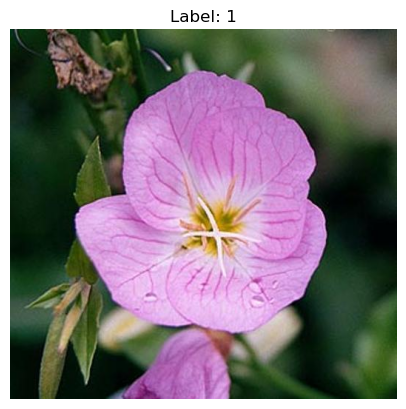

Image size: (500, 666, 3)


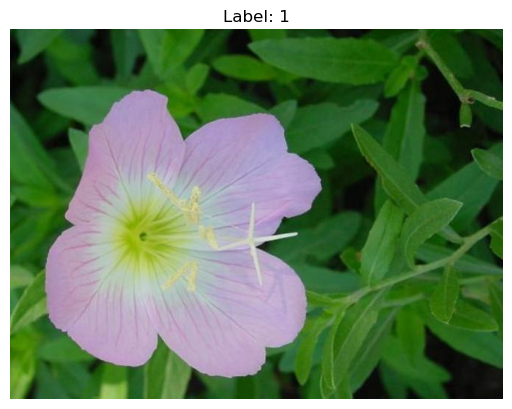

Image size: (500, 595, 3)


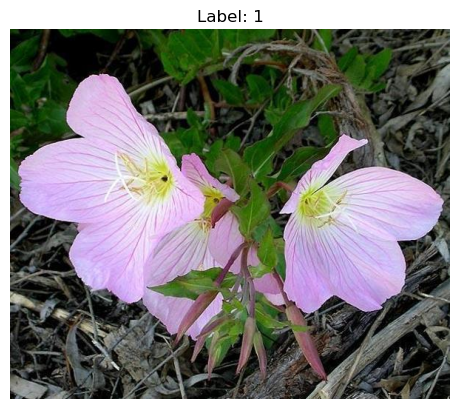

Image size: (500, 553, 3)


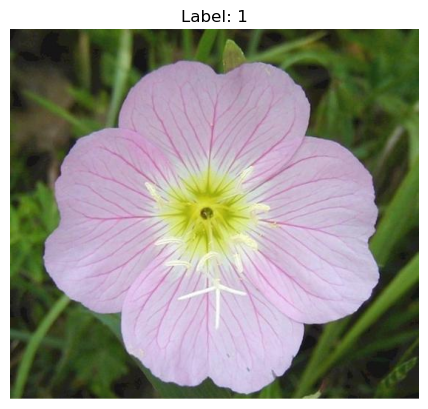

Image size: (601, 500, 3)


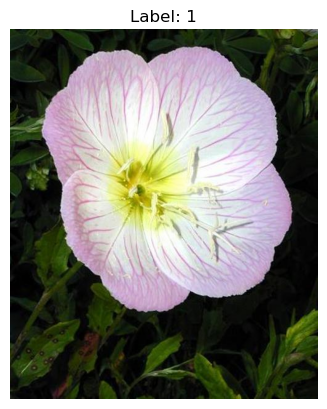

In [4]:
for i in range(5):
    img, label, _ = train_dataset[i]
    print("Image size:", img.shape)
    plot_image(img, title = f"Label: {label}")

### 3. Extract deep convolutional features

We use `DeepConvFeatureExtractor` from our code. For demonstration, we'll pick `vgg16` and the last conv layer.


In [4]:
extractor = DeepConvFeature(
    model=vgg16(weights=VGG16_Weights.DEFAULT),
    layer_index=-4,  # Last conv layer
    spatial_encoding=True,
    device=DEVICE
)

2025-01-06 09:59:55,613 - Feature_Extractor - INFO - Selected layer: features.21, Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### Extract features

**WARNING**: This loads all images and feature maps into memory. Make sure your computer can handle the data.


In [5]:
NUM_IMGS = 500

In [6]:
labels, paths, features = [], [], []
for img, lbl, path in islice(train_dataset, NUM_IMGS):
    labels.append(lbl)
    paths.append(path)
    features.append(extractor(img))

labels = np.array(labels)
features = np.vstack(features)

## **4. Training VLAD Model**
We'll train the K-Means model, which is essential for the VLAD Encoding model. This might take a while.

In [10]:
kmeans_model_no_pca = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
kmeans_model_no_pca.fit(features)
save_model(kmeans_model_no_pca, f"{ROOT}/models/pickle_model_files/k_means_k{NUM_CLUSTERS}_deep_features_vgg16_no_pca.pkl")

If you saved the model previously, and don't want to re-run the train script, you can load the model by executing the cell below:

In [7]:
kmeans_model_no_pca = load_model(f"{ROOT}/models/pickle_model_files/k_means_k{NUM_CLUSTERS}_deep_features_vgg16_no_pca.pkl")

### Declare the VLAD encoder (no PCA)

In [49]:
vlad_encoder_no_pca = VLADEncoder(
    feature_extractor=extractor,
    kmeans_model=kmeans_model_no_pca,
    power_norm_weight=1,
    norm_order=2,
    epsilon=1e-9,
    flatten=True,
)

vlad_data = vlad_encoder_no_pca.generate_encoding_map(paths)

Similar to above, but here, the dimension of each feature vector is reduced `by half` using `PCA`.

In [11]:
dim_pca_vlad = features.shape[1] // DIM_REDUCTION_FACTOR
pca_model_vlad = PCA(n_components=dim_pca_vlad).fit(features)
features_pca_vlad = pca_model_vlad.transform(features)
save_model(pca_model_vlad, f"{ROOT}/models/pickle_model_files/pca_vlad_k{NUM_CLUSTERS}_deep_features_vgg16_feature_dim{dim_pca_vlad}.pkl")

kmeans_model_pca = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
kmeans_model_pca.fit(features_pca_vlad)
save_model(kmeans_model_pca, f"{ROOT}/models/pickle_model_files/k_means_k{NUM_CLUSTERS}_deep_features_vgg16_pca.pkl")

If you saved the model previously, and don't want to re-run the train script, you can load the model by executing the cell below:

In [50]:
dim_pca_vlad = features.shape[1] // DIM_REDUCTION_FACTOR
pca_model_vlad = load_model(f"{ROOT}/models/pickle_model_files/pca_vlad_k{NUM_CLUSTERS}_deep_features_vgg16_feature_dim{dim_pca_vlad}.pkl")
kmeans_model_pca = load_model(f"{ROOT}/models/pickle_model_files/k_means_k{NUM_CLUSTERS}_deep_features_vgg16_pca.pkl")

### Declare the VLAD encoder (with PCA)

In [51]:
vlad_encoder_with_pca = VLADEncoder(
    feature_extractor=extractor,
    kmeans_model=kmeans_model_pca,
    power_norm_weight=1,
    norm_order=2,
    epsilon=1e-9,
    flatten=True,
    pca=pca_model_vlad
)

vlad_data_pca = vlad_encoder_with_pca.generate_encoding_map(paths)

## **5. Compare some images**

We will now use the trained VLAD encoders to compute similarity between some images.

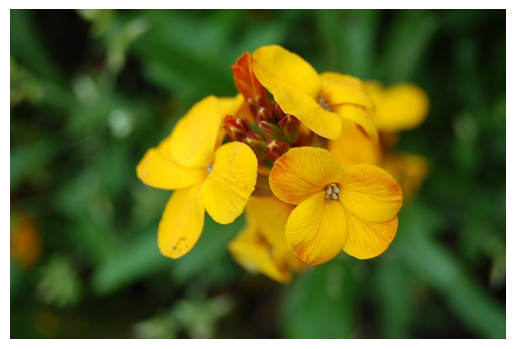

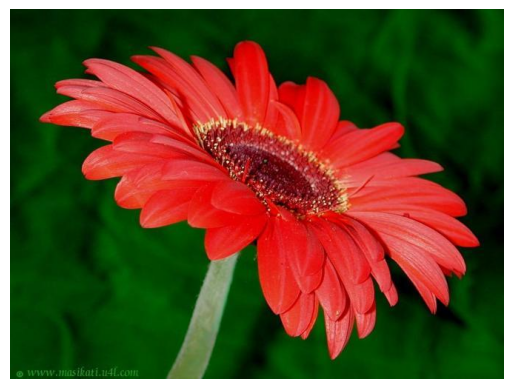

In [52]:
image_1, label_1, path_1 = train_dataset[2005]
image_2, label_2, path_2 =  val_dataset[401]
plot_image(image_1)
plot_image(image_2)

Now, we compare the two images. `cosine similarity` is used in this case.

In [53]:
sim_with_pca = vlad_encoder_with_pca.similarity_score(image_1, image_2)
print("Similarity Score, with PCA: ", sim_with_pca)
sim_without_pca = vlad_encoder_no_pca.similarity_score(image_1, image_2)
print("Similarity Score, without PCA: ", sim_without_pca)

Similarity Score, with PCA:  0.291814923286438
Similarity Score, without PCA:  0.23219512403011322


## **6. Fetch the most similar image in the dataset, given a query image**

Now, we will select an image in the validation dataset, on which the model is not yet trained:

In [54]:
query_image, query_label, query_path =  val_dataset[101]

Retrieve top-k most similar images using the datasets computed. We will see how it works, with and without PCA.

In [55]:
top_k_vlad_pca = retrieve_top_k_similar(query_image, vlad_data_pca, vlad_encoder_with_pca)
for path, score in top_k_vlad_pca:
    print(f"Path: {os.path.basename(path)}, Cosine similarity: {score:.4f}")

tok_k_vlad_no_pca = retrieve_top_k_similar(query_image, vlad_data, vlad_encoder_no_pca)
for path, score in tok_k_vlad_no_pca:
    print(f"Path: {os.path.basename(path)}, Cosine similarity: {score:.4f}")

Path: image_03161.jpg, Cosine similarity: 0.3851
Path: image_03143.jpg, Cosine similarity: 0.3729
Path: image_03159.jpg, Cosine similarity: 0.3713
Path: image_03130.jpg, Cosine similarity: 0.3538
Path: image_03121.jpg, Cosine similarity: 0.3515
Path: image_03143.jpg, Cosine similarity: 0.3706
Path: image_03161.jpg, Cosine similarity: 0.3642
Path: image_03159.jpg, Cosine similarity: 0.3543
Path: image_03173.jpg, Cosine similarity: 0.3496
Path: image_03130.jpg, Cosine similarity: 0.3475


In [56]:
most_similar_image_path_vlad_pca, top_score_vlad_pca = top_k_vlad_pca[0]
most_similar_image_label_vlad_pca = train_dataset.labels[train_dataset.image_paths.index(most_similar_image_path_vlad_pca)]

most_similar_image_path_vlad_no_pca, top_score_vlad_no_pca = tok_k_vlad_no_pca[0]
most_similar_image_label_vlad_no_pca = train_dataset.labels[train_dataset.image_paths.index(most_similar_image_path_vlad_no_pca)]
print("Highest similarity score, with PCA: ", top_score_vlad_pca)
print("Highest similarity score, no PCA: ", top_score_vlad_no_pca)

Highest similarity score, with PCA:  0.38510922
Highest similarity score, no PCA:  0.37059245


### Let's plot both images next to each other.


a) Using Model trained on data with PCA

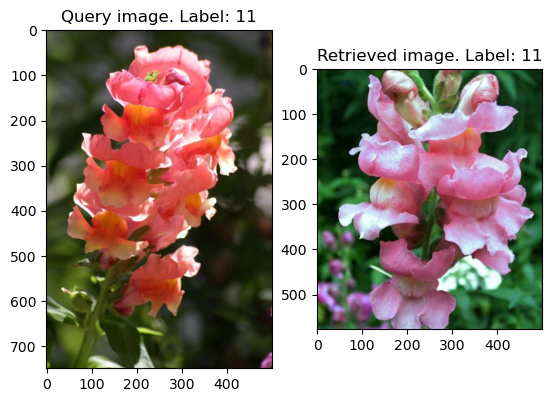

In [57]:
most_similar_image_pca = cv2.cvtColor(cv2.imread(most_similar_image_path_vlad_pca), cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 1)
plt.imshow(query_image)
plt.title(f"Query image. Label: {query_label}")

plt.subplot(1, 2, 2)
plt.imshow(most_similar_image_pca)
plt.title(f"Retrieved image. Label: {most_similar_image_label_vlad_pca}")

plt.show()

b) Using model trained on full data

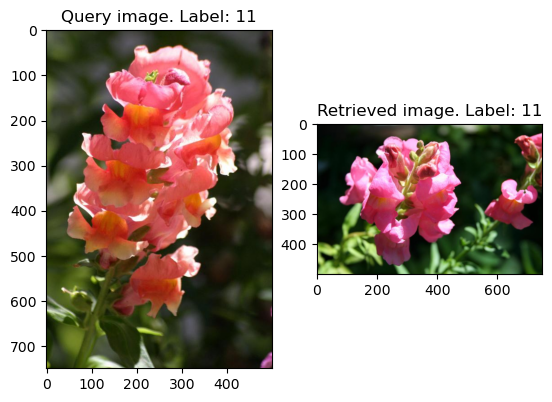

In [58]:
most_similar_image_no_pca = cv2.cvtColor(cv2.imread(most_similar_image_path_vlad_no_pca), cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 1)
plt.imshow(query_image)
plt.title(f"Query image. Label: {query_label}")

plt.subplot(1, 2, 2)
plt.imshow(most_similar_image_no_pca)
plt.title(f"Retrieved image. Label: {most_similar_image_label_vlad_no_pca}")

plt.show()

## **7. Similar to above, we will do the exact things for the Fisher Vector**

The implementation for both VLAD and Fisher Vectors are identical. After all, VLAD is simply a simplified case of Fisher Vector.

### Fit GMM model

In [24]:
gmm_model_no_pca = GaussianMixture(n_components=NUM_CLUSTERS, covariance_type='diag', random_state=42)
gmm_model_no_pca.fit(features)
save_model(gmm_model_no_pca, f"{ROOT}/models/pickle_model_files/gmm_k{NUM_CLUSTERS}_deep_features_vgg16_no_pca.pkl")

C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


If you saved the model previously, and don't want to re-run the train script, you can load the model by executing the cell below:

In [29]:
gmm_model_no_pca = load_model(f"{ROOT}/models/pickle_model_files/gmm_k{NUM_CLUSTERS}_deep_features_vgg16_no_pca.pkl")

### Instantiate Fisher Vector Encoder without PCA

In [42]:
fisher_encoder_no_pca = FisherVectorEncoder(
    feature_extractor=extractor,
    gmm_model=gmm_model_no_pca,
    power_norm_weight=0.5,
    norm_order=2,
    epsilon=1e-9,
    flatten=True,
)

fisher_data = fisher_encoder_no_pca.generate_encoding_map(paths)

### Using PCA to reduce features by half

In [24]:
dim_pca_fisher = features.shape[1] // DIM_REDUCTION_FACTOR
pca_model_fisher = PCA(n_components=dim_pca_fisher).fit(features)
features_pca_fisher = pca_model_fisher.transform(features)
save_model(pca_model_fisher, f"{ROOT}/models/pickle_model_files/pca_fisher_k{NUM_CLUSTERS}_deep_features_vgg16_feature_dim{dim_pca_fisher}.pkl")

gmm_model_pca = GaussianMixture(n_components=NUM_CLUSTERS, covariance_type='diag', random_state=42)
gmm_model_pca.fit(features_pca_fisher)
save_model(gmm_model_pca, f"{ROOT}/models/pickle_model_files/gmm_k{NUM_CLUSTERS}_deep_features_vgg16_pca.pkl")

C:\Users\STUD_VuNhat\AppData\Local\anaconda3\envs\conda_env\Lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


If you saved the model previously, and don't want to re-run the train script, you can load the model by executing the cell below:

In [43]:
dim_pca_fisher = features.shape[1] // DIM_REDUCTION_FACTOR
pca_model_fisher = load_model(f"{ROOT}/models/pickle_model_files/pca_fisher_k{NUM_CLUSTERS}_deep_features_vgg16_feature_dim{dim_pca_fisher}.pkl")
gmm_model_pca = load_model(f"{ROOT}/models/pickle_model_files/gmm_k{NUM_CLUSTERS}_deep_features_vgg16_pca.pkl")

### Instantiate Fisher Vector Encoder with PCA

In [44]:
fisher_encoder_with_pca = FisherVectorEncoder(
    feature_extractor=extractor,
    gmm_model=gmm_model_pca,
    power_norm_weight=0.5,
    norm_order=2,
    epsilon=1e-9,
    flatten=True,
    pca=pca_model_fisher,
)

fisher_data_pca = fisher_encoder_with_pca.generate_encoding_map(paths)

### Compute similarity of two images

In [45]:
image_similarity_with_pca = fisher_encoder_with_pca.similarity_score(image_1, image_2)
image_similarity_without_pca = fisher_encoder_no_pca.similarity_score(image_1, image_2)
print("Fisher Similarity Score, with PCA: ", image_similarity_with_pca)
print("Fisher Similarity Score, without PCA: ", image_similarity_without_pca)

Fisher Similarity Score, with PCA:  0.8607430021480108
Fisher Similarity Score, without PCA:  0.1891182356973808


### Retrieve top-k most similar images

In [59]:
top_k_fisher_pca = retrieve_top_k_similar(query_image, fisher_data_pca, fisher_encoder_with_pca)
print("Evaluation of fisher vector with PCA:")
for path, score in top_k_fisher_pca:
    print(f"Path: {os.path.basename(path)}, Cosine similarity: {score:.4f}")

top_k_fisher_no_pca = retrieve_top_k_similar(query_image, fisher_data, fisher_encoder_no_pca)
print("\nEvaluation of Fisher Vector without PCA:")
for path, score in top_k_fisher_no_pca:
    print(f"Path: {os.path.basename(path)}, Cosine similarity: {score:.4f}")

Evaluation of fisher vector with PCA:
Path: image_03159.jpg, Cosine similarity: 0.9630
Path: image_03130.jpg, Cosine similarity: 0.9624
Path: image_03143.jpg, Cosine similarity: 0.9614
Path: image_03135.jpg, Cosine similarity: 0.9600
Path: image_03124.jpg, Cosine similarity: 0.9564

Evaluation of Fisher Vector without PCA:
Path: image_05111.jpg, Cosine similarity: 0.6892
Path: image_03141.jpg, Cosine similarity: 0.6876
Path: image_05645.jpg, Cosine similarity: 0.6707
Path: image_07190.jpg, Cosine similarity: 0.6699
Path: image_05149.jpg, Cosine similarity: 0.5903


### Query images

In [37]:
most_similar_image_path_fisher_pca, top_score_fisher_pca = top_k_fisher_pca[0]
most_similar_image_label_fisher_pca = train_dataset.labels[
    train_dataset.image_paths.index(most_similar_image_path_fisher_pca)]

most_similar_image_path_fisher_no_pca, top_score_fisher_no_pca = top_k_fisher_no_pca[0]
most_similar_image_label_fisher_no_pca = train_dataset.labels[
    train_dataset.image_paths.index(most_similar_image_path_fisher_no_pca)]
print("Highest similarity score, with PCA: ", top_score_fisher_pca)
print("Highest similarity score, no PCA: ", top_score_fisher_no_pca)

Highest similarity score, with PCA:  0.9191774306912208
Highest similarity score, no PCA:  0.7028785663446854


### Let's plot both images next to each other.
a) Using Model trained on Data with PCA

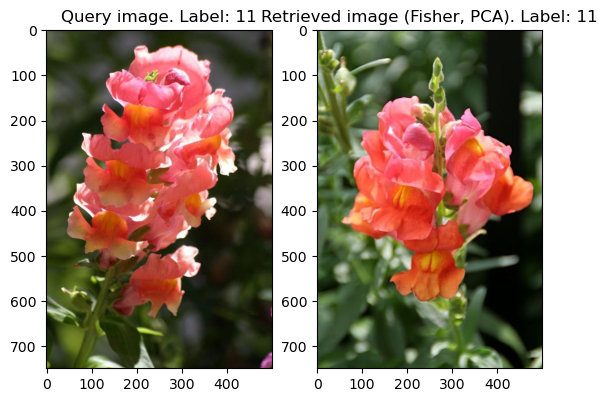

In [47]:
most_similar_image_pca = cv2.cvtColor(cv2.imread(most_similar_image_path_fisher_pca), cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 1)
plt.imshow(query_image)
plt.title(f"Query image. Label: {query_label}")

plt.subplot(1, 2, 2)
plt.imshow(most_similar_image_pca)
plt.title(f"Retrieved image (Fisher, PCA). Label: {most_similar_image_label_fisher_pca}")

plt.show()

b) Using Model trained on full data

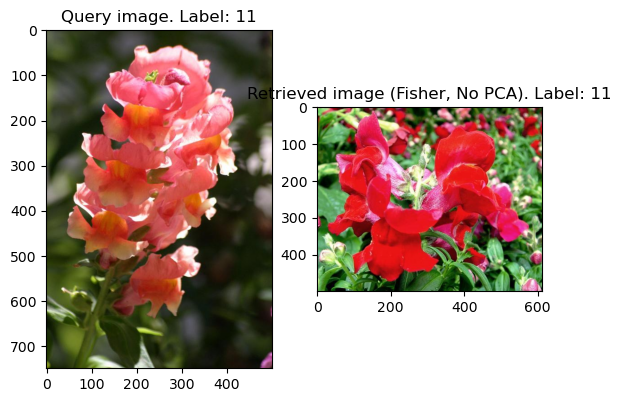

In [48]:
most_similar_image_no_pca = cv2.cvtColor(cv2.imread(most_similar_image_path_fisher_no_pca), cv2.COLOR_BGR2RGB)
plt.subplot(1, 2, 1)
plt.imshow(query_image)
plt.title(f"Query image. Label: {query_label}")

plt.subplot(1, 2, 2)
plt.imshow(most_similar_image_no_pca)
plt.title(f"Retrieved image (Fisher, No PCA). Label: {most_similar_image_label_fisher_no_pca}")

plt.show()

## **7. Now, let's compute the top-k accuracy of our retrieval.**

In [ ]:
def compute_map(queries: list[np.ndarray],
                query_labels: list[int],
                dataset: dict[str, np.ndarray],
                dataset_labels: dict[str, int],
                encoder) -> float:
    """
    Computes mean Average Precision over the queries,
    based on whether retrieved images have matching labels.

    :param queries: List of query images (NumPy arrays).
    :param query_labels: Corresponding labels for the queries.
    :param dataset: dict {img_path: feature_vector}
    :param dataset_labels: dict {img_path: label}
    :param encoder: Object with `compute_vector(img) -> np.ndarray`.
    :return: mAP (float)
    """
    all_vectors = np.array(list(dataset.values()))  # (N, D)
    all_paths = list(dataset.keys())  # (N,)

    # For label_ranking_average_precision_score,
    # we need a (n_samples, n_labels) "indicator matrix" of true labels
    # For single-label classification, we can approach it a bit differently.
    # Let's do a manual approach:

    APs = []
    for query_img, true_label in zip(queries, query_labels):
        query_vec = encoder.encode(query_img)
        if query_vec.ndim == 1:
            query_vec = query_vec.reshape(1, -1)

        sims = cosine_similarity(query_vec, all_vectors)[0]  # shape: (N,)

        # Sort by descending similarity
        sorted_idx = np.argsort(-sims)
        sorted_paths = [all_paths[i] for i in sorted_idx]

        # We'll compute average precision by counting relevant images at each rank
        relevant_count = 0
        precision_sum = 0.0
        for rank, path in enumerate(sorted_paths, start=1):
            if dataset_labels[path] == true_label:
                relevant_count += 1
                precision_sum += (relevant_count / rank)

        # If there are R relevant images in the entire dataset
        # average precision = sum(precision_at_i for each relevant i) / R
        R = sum(lbl == true_label for lbl in dataset_labels.values())
        if R > 0:
            AP = precision_sum / R
        else:
            AP = 0.0

        APs.append(AP)

    return float(np.mean(APs))

## **8. Conclusion**

We have demonstrated:
1. Training VLAD and Fisher Vector Encoders on deep embeddings of VGG-15 Models.
2. Clustering images for different cluster sizes.
3. Comparing PCA vs. No PCA approaches.